In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

# Read Data

In [3]:
data_0 = pandas.read_csv('Data/hits.csv', index_col=0)

data_1 = data_0.copy()
data_1['Wy1'] = data_0['Wy1'].values + data_0.dist2Wire.values
data_1['Wy2'] = data_0['Wy2'].values + data_0.dist2Wire.values
data_2 = data_0.copy()
data_2['Wy1'] = data_0['Wy1'].values - data_0.dist2Wire.values
data_2['Wy2'] = data_0['Wy2'].values - data_0.dist2Wire.values
data = pandas.concat([data_1, data_2], axis=0)

data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,dist2Wire,Wx1,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,0.042245,-250.000000,250.000000,0.910845,0.910845,2581.1500,2581.1500,2581.1500,0,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,0.478996,-248.589486,249.507863,27.516483,-16.061389,3542.3793,3542.3793,3542.3793,0,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,0.310706,-248.587499,249.509850,-26.749494,16.828378,2592.3793,2592.3793,2592.3793,0,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,0.117904,-248.894287,249.203062,-23.435691,20.142180,2592.3793,2592.3793,2592.3793,1,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,0.437575,-250.000000,250.000000,0.426175,0.426175,2782.2500,2782.2500,2782.2500,0,0


# Tracks Reconstruction

In [5]:
from baseline import SimpleTemplateMatching
from hough import LinearHoughModel
from reconstruction import TracksReconstruction2D
from combination import Combinator


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [5]:
event = data[data.EventID == 2]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

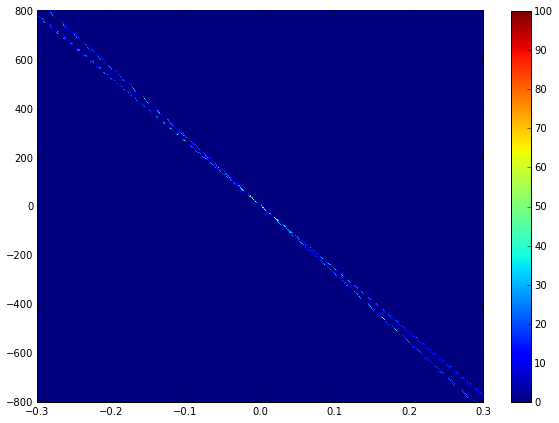

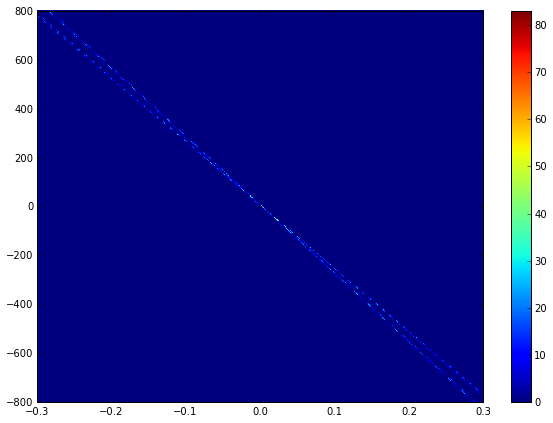

CPU times: user 3.25 s, sys: 891 ms, total: 4.15 s
Wall time: 4.15 s


In [6]:
%%time
lhm = LinearHoughModel(k_params=(-0.3, 0.3, 3000), b_params=(-800, 800, 3000), n_candidates=2, show=True)
lhm.fit(x, y)

labels = lhm.labels_
tracks_params = lhm.tracks_params_

In [7]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [8]:
tracks_params

array([[ -1.67595759e-03,   5.09823132e+00],
       [  6.49413599e-03,  -1.28987725e+01]])

In [9]:
labels

array([ 0.,  0., -1.,  0.,  1.,  0., -1.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0., -1.,  0., -1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        0., -1.,  1.,  1., -1., -1., -1.,  1.])

In [10]:
event12.Label.values

array([ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.])

### Track Params Distributions

In [11]:
event_ids = numpy.unique(data.EventID.values)

tracks_y = pandas.DataFrame(columns=['EventID', 'Track12Y0_k', 'Track12Y0_b', 'Track12Y1_k', 'Track12Y1_b', 
                                                'Track34Y0_k', 'Track34Y0_b', 'Track34Y1_k', 'Track34Y1_b'])
tracks_stereo = pandas.DataFrame(columns=['EventID', 'Track12Stereo0_k', 'Track12Stereo0_b', 'Track12Stereo1_k', 'Track12Stereo1_b', 
                                                'Track34Stereo0_k', 'Track34Stereo0_b', 'Track34Stereo1_k', 'Track34Stereo1_b'])

for event_id in event_ids:
    
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    track12_y_0 = event12[(event12.IsStereo == 0)*(event12.Label == 0)]
    track12_y_1 = event12[(event12.IsStereo == 0)*(event12.Label == 1)]
    
    track12_stereo_0 = event34[(event34.IsStereo == 1)*(event34.Label == 0)]
    track12_stereo_1 = event34[(event34.IsStereo == 1)*(event34.Label == 1)]
    
    track34_y_0 = event34[(event34.IsStereo == 0)*(event34.Label == 0)]
    track34_y_1 = event34[(event34.IsStereo == 0)*(event34.Label == 1)]
    
    track34_stereo_0 = event34[(event34.IsStereo == 1)*(event34.Label == 0)]
    track34_stereo_1 = event34[(event34.IsStereo == 1)*(event34.Label == 1)]
    
    if len(track12_y_0) < 2 or len(track12_y_1) < 2 or len(track12_stereo_0) < 2 or len(track12_stereo_1) < 2:
        print event_id
        continue
        
    if len(track34_y_0) < 2 or len(track34_y_1) < 2 or len(track34_stereo_0) < 2 or len(track34_stereo_1) < 2:
        print event_id
        continue
    
    params12_y_0 = numpy.polyfit(track12_y_0.Z.values, track12_y_0.Y.values, 1)
    params12_y_1 = numpy.polyfit(track12_y_1.Z.values, track12_y_1.Y.values, 1)
    params34_y_0 = numpy.polyfit(track34_y_0.Z.values, track34_y_0.Y.values, 1)
    params34_y_1 = numpy.polyfit(track34_y_1.Z.values, track34_y_1.Y.values, 1)
    
    tracks_y.loc[len(tracks_y)] = [event_id] + \
                                  list(params12_y_0) + \
                                  list(params12_y_1) + \
                                  list(params34_y_0) + \
                                  list(params34_y_1)
                    
    
    params12_stereo_0 = numpy.polyfit(track12_stereo_0.Z.values, track12_stereo_0.X.values, 1)
    params12_stereo_1 = numpy.polyfit(track12_stereo_1.Z.values, track12_stereo_1.X.values, 1)
    params34_stereo_0 = numpy.polyfit(track34_stereo_0.Z.values, track34_stereo_0.X.values, 1)
    params34_stereo_1 = numpy.polyfit(track34_stereo_1.Z.values, track34_stereo_1.X.values, 1)
    
    tracks_stereo.loc[len(tracks_stereo)] = [event_id] + \
                                  list(params12_stereo_0) + \
                                  list(params12_stereo_1) + \
                                  list(params34_stereo_0) + \
                                  list(params34_stereo_1)

143
270
1528
1722
2040
3670
3781


-0.31330262463 0.267953849487 9.20882630273e-06
-750.961451143 817.048339917 0.011920829944


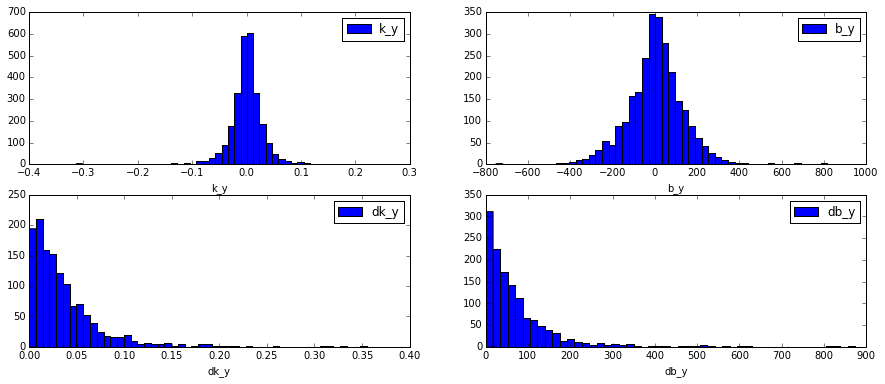

In [12]:
k_y = numpy.concatenate((tracks_y.Track12Y0_k.values, tracks_y.Track12Y1_k.values, 
                         tracks_y.Track34Y0_k.values, tracks_y.Track34Y1_k.values), axis=0)

dk_y = numpy.concatenate((numpy.abs(tracks_y.Track12Y0_k.values - tracks_y.Track12Y1_k.values), 
                         numpy.abs(tracks_y.Track34Y0_k.values - tracks_y.Track34Y1_k.values)), axis=0)

b_y = numpy.concatenate((tracks_y.Track12Y0_b.values, tracks_y.Track12Y1_b.values, 
                         tracks_y.Track34Y0_b.values, tracks_y.Track34Y1_b.values), axis=0)

db_y = numpy.concatenate((numpy.abs(tracks_y.Track12Y0_b.values - tracks_y.Track12Y1_b.values), 
                         numpy.abs(tracks_y.Track34Y0_b.values - tracks_y.Track34Y1_b.values)), axis=0)


print k_y.min(), k_y.max(), dk_y.min()
print b_y.min(), b_y.max(), db_y.min()


plt.figure(figsize=(15, 6))

plt.subplot(2,2,1)
plt.hist(k_y, label='k_y', bins=50)
plt.xlabel('k_y')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.hist(b_y, label='b_y', bins=50)
plt.xlabel('b_y')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.hist(dk_y, label='dk_y', bins=50)
plt.xlabel('dk_y')
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.hist(db_y, label='db_y', bins=50)
plt.xlabel('db_y')
plt.legend(loc='best')

plt.show()

-0.121089450026 0.170924586069 9.04621473547e-05
-432.65159682 403.016068086 0.00367002685756


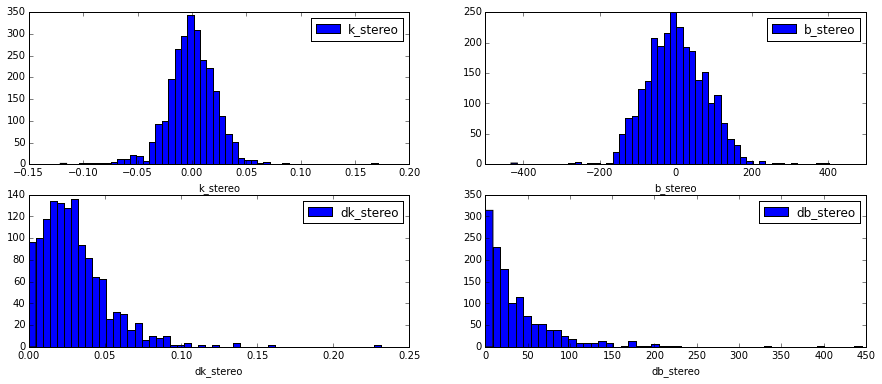

In [13]:
k_stereo = numpy.concatenate((tracks_stereo.Track12Stereo0_k.values, tracks_stereo.Track12Stereo1_k.values, 
                         tracks_stereo.Track34Stereo0_k.values, tracks_stereo.Track34Stereo1_k.values), axis=0)

dk_stereo = numpy.concatenate((numpy.abs(tracks_stereo.Track12Stereo0_k.values - tracks_stereo.Track12Stereo1_k.values), 
                         numpy.abs(tracks_stereo.Track34Stereo0_k.values - tracks_stereo.Track34Stereo1_k.values)), axis=0)

b_stereo = numpy.concatenate((tracks_stereo.Track12Stereo0_b.values, tracks_stereo.Track12Stereo1_b.values, 
                         tracks_stereo.Track34Stereo0_b.values, tracks_stereo.Track34Stereo1_b.values), axis=0)

db_stereo = numpy.concatenate((numpy.abs(tracks_stereo.Track12Stereo0_b.values - tracks_stereo.Track12Stereo1_b.values), 
                         numpy.abs(tracks_stereo.Track34Stereo0_b.values - tracks_stereo.Track34Stereo1_b.values)), axis=0)


print k_stereo.min(), k_stereo.max(), dk_stereo.min()
print b_stereo.min(), b_stereo.max(), db_stereo.min()


plt.figure(figsize=(15, 6))

plt.subplot(2,2,1)
plt.hist(k_stereo, label='k_stereo', bins=50)
plt.xlabel('k_stereo')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.hist(b_stereo, label='b_stereo', bins=50)
plt.xlabel('b_stereo')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.hist(dk_stereo, label='dk_stereo', bins=50)
plt.xlabel('dk_stereo')
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.hist(db_stereo, label='db_stereo', bins=50)
plt.xlabel('db_stereo')
plt.legend(loc='best')

plt.show()

### Tracks Reconstruction

In [14]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = numpy.unique(data.EventID.values)
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = LinearHoughModel(k_params=(-0.35, 0.35, 5000), b_params=(-850, 850, 4000), n_candidates=2, show=False)
    stm_stereo = LinearHoughModel(k_params=(-0.3, 0.3, 100), b_params=(-500, 500, 100), n_candidates=1, show=False)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

CPU times: user 2.97 s, sys: 737 ms, total: 3.71 s
Wall time: 50min 49s


In [15]:
#tracks_reconstruction(2)

In [16]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in tracks.keys():
    
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    comb = Combinator(dy_max=2, dx_max=20)
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    pass_stages.loc[len(pass_stages)] = numpy.array([1, 
                                                     (trm12.recognition_efficiency_y_ == 1)*1, 
                                                     (trm12.recognition_efficiency_stereo_ >= 0.5)*1, 
                                                     (trm12.recognition_efficiency_ == 1)*1,
                                                     (trm34.recognition_efficiency_y_ == 1)*1, 
                                                     (trm34.recognition_efficiency_stereo_ >= 0.5)*1, 
                                                     (trm34.recognition_efficiency_ == 1)*1, 
                                                     (cq.n_combined_ >= 2)*1,
                                                     (cq.reco_eff_ == 1)*1]).cumprod()


CPU times: user 28 s, sys: 476 ms, total: 28.5 s
Wall time: 28.6 s


In [17]:
(combinations_quality.head(10).RecoEff.values == 1).sum()

9

In [18]:
tracks_metrics_before_stereo.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,4097,1.000000,1,0,0
1,2,1.000000,1,0,0
2,4267,1.000000,1,0,0
3,7,0.894737,1,0,0
4,4453,1.000000,1,0,0
5,3081,1.000000,1,0,0
6,10,1.000000,1,0,0
7,2059,1.000000,1,0,0
8,1036,1.000000,1,0,0
9,3085,0.796296,1,0,0


In [19]:
tracks_metrics_before_y.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,4097,1.000000,1,0,0
1,2,1.000000,1,0,0
2,4267,1.000000,1,0,0
3,7,1.000000,1,0,0
4,4453,1.000000,1,0,0
5,3081,1.000000,1,0,0
6,10,1.000000,1,0,0
7,2059,1.000000,1,0,0
8,1036,0.937500,1,0,0
9,3085,0.615942,1,0,0


# Quality

# Stations 1&2

### Y-views

In [20]:
tracks_metrics_before_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.994647
RecoEff         1.000000
GhostRate       0.000000
CloneRate       0.001493
dtype: float64

### Stereo-views

In [21]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.988957
RecoEff         0.998507
GhostRate       0.000746
CloneRate       0.000000
dtype: float64

### Stations 1&2

In [22]:
tracks_metrics_before_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.990067
RecoEff         0.998507
GhostRate       0.000746
CloneRate       0.000746
dtype: float64

### Track efficiency

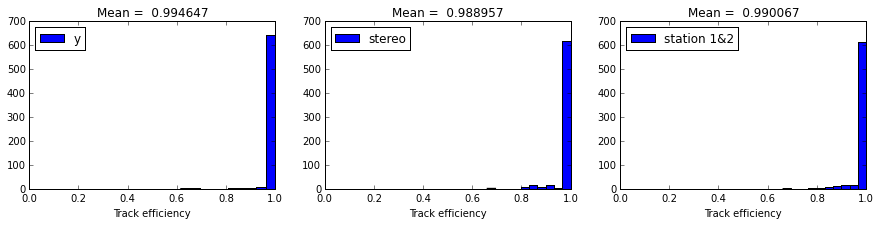

In [23]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

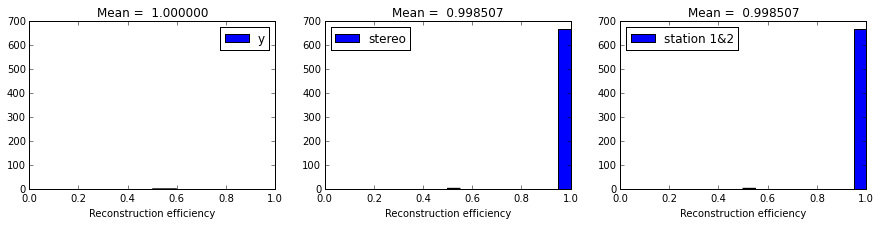

In [24]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [25]:
tracks_metrics_after_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.994842
RecoEff         0.999254
GhostRate       0.002239
CloneRate       0.008955
dtype: float64

### Stereo-views

In [26]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.990539
RecoEff         0.994030
GhostRate       0.001493
CloneRate       0.001493
dtype: float64

### Station 3&4

In [27]:
tracks_metrics_after_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.991803
RecoEff         0.994030
GhostRate       0.001493
CloneRate       0.004478
dtype: float64

### Tracks efficiency

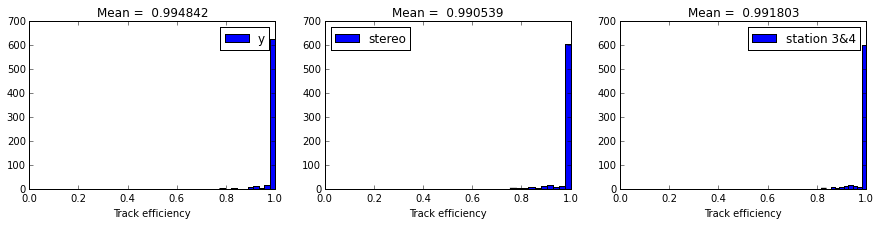

In [28]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

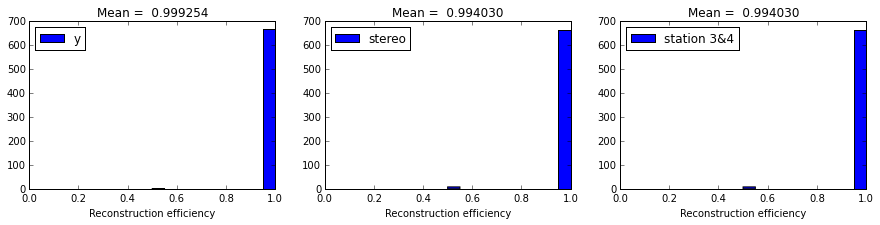

In [29]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [30]:
combinations_quality.mean(axis=0)

EventID      2555.164179
RecoEff         0.988060
GhostRate       0.001493
CloneRate       0.000746
NCombined       1.977612
dtype: float64

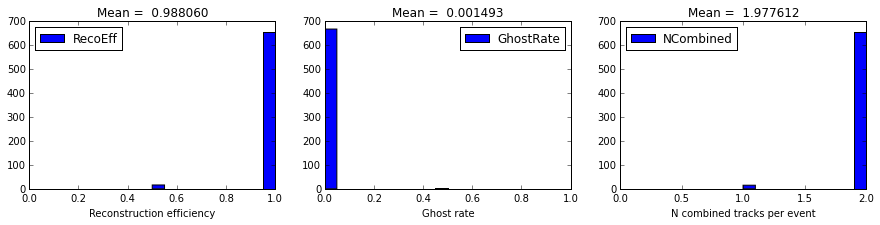

In [31]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

97.6119402985


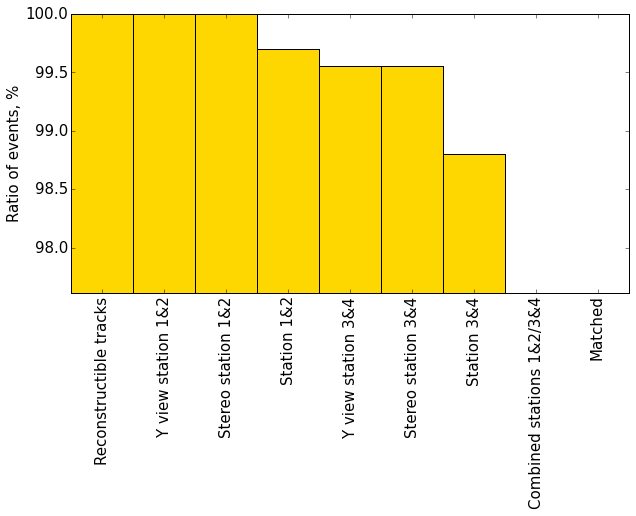

In [32]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages.sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

In [33]:
bar_values

array([ 100.        ,  100.        ,  100.        ,   99.70149254,
         99.55223881,   99.55223881,   98.80597015,   97.6119403 ,
         97.6119403 ])

# Momentum

In [34]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

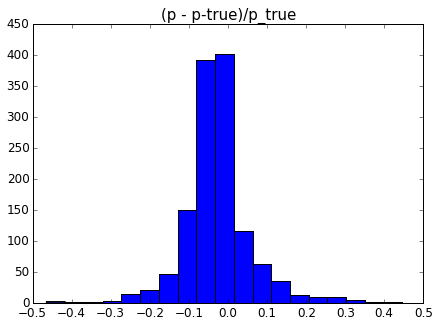

In [48]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)], bins=50)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()

In [49]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

2